# Testing Different Algorithms to Update Weights

Just as convolutional networks encode the spatial relationship between input pixels, I tested several different ways to update the weights in a network according to the spatial layout of the input neurons to encode this spatial information.

Overall, I was not able to find a significant improvement over standard backpropagation, but it was interesting to try.

## Load Data

In [1]:
from typing import *
import numpy as np
from matplotlib import pyplot as plt
from data_loader import load_data

np.set_printoptions(suppress=True, precision=2)
np.random.seed(216)

In [2]:
# Could take 10 to 20 seconds
train_images, train_labels, test_images, test_labels = load_data("fashion_mnist")

# flatten and collect data
training_data = [(x.flatten(), y) for x, y in zip(train_images, train_labels)]
testing_data = [(x.flatten(), y) for x, y in zip(test_images, test_labels)]

## Weight Update Algorithms

### Compare network performances

In [3]:
from network import *
from layers import *
from loss import *

### New `Dense` class with new weight update algorithm

In [ ]:
class Dense(TrainableLayer):
    """Implementation of a dense (fully connected) layer."""

    def __init__(
        self,
        input_size: int,
        output_size: int,
        regularization_parameter: np.float64 = 0.,
        roll: bool = False,
        weights: Optional[np.ndarray] = None,
        biases: Optional[np.ndarray] = None
    ) -> None:
        super().__init__(input_size, output_size, regularization_parameter)
        
        if weights is None:
            self.weights = np.random.randn(self.output_size, self.input_size)
            # Scale weights to standardize output distribution
            self.weights /= np.sqrt(self.input_size)
        else:
            self.weights = weights

        if biases is None:
            self.biases = np.random.randn(self.output_size)
        else:
            self.biases = biases
        
        self.roll = False
        
        # nabla_w and nabla_b are derivatives of weights and biases, summed over
        # a mini batch.
        self.nabla_w = np.zeros(self.weights.shape, np.float64)
        self.nabla_b = np.zeros(self.biases.shape, np.float64)

    def reset(self) -> None:
        self.weights = np.random.randn(self.output_size, self.input_size)
        self.weights /= np.sqrt(self.input_size)
        self.biases = np.random.randn(self.output_size)
        self.nabla_w.fill(0.)
        self.nabla_b.fill(0.)

    def forward(
        self,
        input_data: np.ndarray[np.float64]
    ) -> np.ndarray[np.float64]:
        """Pass some data forward. If training, stores input."""
        if self.training:
            self.input = input_data.copy()
        
        return self.biases + np.dot(self.weights, input_data)

    def backprop(self, error: np.ndarray) -> np.ndarray:
        """Backpropagate error. If training, updates gradients."""
        if self.training:
            self.nabla_b -= error
            self.nabla_w -= np.outer(error, self.input)
        return np.dot(self.weights.transpose(), error)

    def regularize_parameters(
        self,
        training_size: int,
        learning_rate: np.float64
    ) -> None:
        """Regularize weights."""
        self.weights *= (1 - learning_rate * (
            self.regularization_parameter / training_size
        ))

    def update_parameters(
            self,
            learning_rate: np.float64,
    ) -> None:
        """Update layer parameters using currently stored gradients."""
        self.biases -= self.nabla_b * learning_rate
        
        if self.roll:
            self.weights -= np.roll(self.nabla_w, -29, 1) * (learning_rate * 0.1)
            self.weights -= np.roll(self.nabla_w, -28, 1) * (learning_rate * 0.1)
            self.weights -= np.roll(self.nabla_w, -27, 1) * (learning_rate * 0.1)
            self.weights -= np.roll(self.nabla_w, -1, 1) * (learning_rate * 0.1)
            self.weights -= self.nabla_w * (learning_rate * 0.2)
            self.weights -= np.roll(self.nabla_w, 1, 1) * (learning_rate * 0.1)
            self.weights -= np.roll(self.nabla_w, 27, 1) * (learning_rate * 0.1)
            self.weights -= np.roll(self.nabla_w, 28, 1) * (learning_rate * 0.1)
            self.weights -= np.roll(self.nabla_w, 29, 1) * (learning_rate * 0.1)

        else:
            self.weights -= self.nabla_w * learning_rate

        self.nabla_w.fill(0.)
        self.nabla_b.fill(0.)

In [4]:
layers = [
    Dense(784, 30, regularization_parameter=5),
    LeakyReLU(30, 0.1),
    Dense(30, 10, regularization_parameter=5),
    LeakyReLU(10, 0.1),
    Softmax(10)
]
standard_network = Network(layers, 0.02, 10)

In [5]:
layers = [
    Dense(784, 30, regularization_parameter=5, roll=True),
    LeakyReLU(30, 0.1),
    Dense(30, 10, regularization_parameter=5),
    LeakyReLU(10, 0.1),
    Softmax(10)
]
broad_network = Network(layers, 0.02, 10)

In [6]:
layers = [
    Dense(784, 30, regularzation_parameter=5, roll=True,
          weights=standard_network.layers[0].weights,
          biases=standard_network.layers[0].biases),
    LeakyReLU(30, 0.1),
    Dense(30, 10, regularzation_parameter=5,
          weights=standard_network.layers[2].weights,
          biases=standard_network.layers[2].biases),
    LeakyReLU(10, 0.1),
    Softmax(10)
]
broad_same_network = Network(layers, 0.02, 10)

In [7]:
standard_network.set_training(True)
broad_network.set_training(True)
broad_same_network.set_training(True)

c1 = c2 = c3 = 0

runs = 10
for i in range(runs):
    standard_network.reset()
    broad_network.reset()
    broad_same_network.reset()

    standard_network.train(5, training_data, NLL(), suppress=True)
    correct = standard_network.evaluate(testing_data)
    p1 = round(correct / 100, 1)
    c1 += correct

    broad_network.train(5, training_data, NLL(), suppress=True)
    correct = broad_network.evaluate(testing_data)
    p2 = round(correct / 100, 1)
    c2 += correct
    
    broad_same_network.train(5, training_data, NLL(), suppress=True)
    correct = broad_same_network.evaluate(testing_data)
    p3 = round(correct / 100, 1)
    c3 += correct

    print(f"Run {i+1} standard, scaled, subtracted scores: {p1}, {p2}, {p3}")

total = len(testing_data) * runs
p1 = round(c1 / total * 100, 1)
p2 = round(c2 / total * 100, 1)
p3 = round(c3 / total * 100, 1)
print(f"Standard: {c1} / {total} ({p1}%)")
print(f"Broad new: {c2} / {total} ({p2}%)")
print(f"Broad same: {c3} / {total} ({p3}%)")

Run 1 standard, scaled, subtracted scores: 84.8, 76.7, 57.4


KeyboardInterrupt: 

### Plot weights

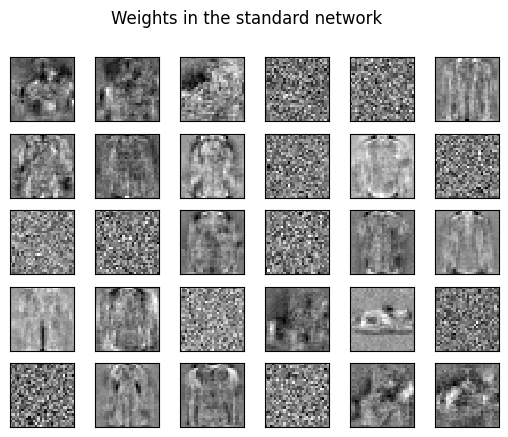

In [ ]:
fig, axes = plt.subplots(5, 6)
fig.suptitle("Weights in the standard network")
for i in range(30):
    ax = axes[i // 6, i % 6]
    im = standard_network.layers[0].weights[i].reshape(28, 28)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")

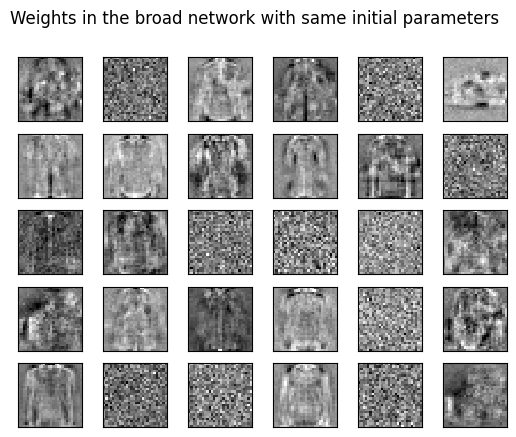

In [ ]:
fig, axes = plt.subplots(5, 6)
fig.suptitle("Weights in the broad network with same initial parameters")
for i in range(30):
    ax = axes[i // 6, i % 6]
    im = broad_same_network.layers[0].weights[i].reshape(28, 28)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")

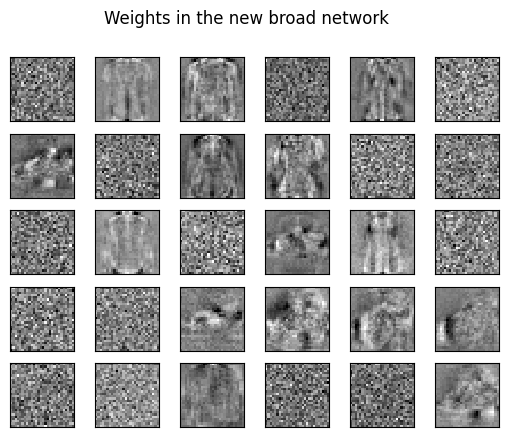

In [ ]:
fig, axes = plt.subplots(5, 6)
fig.suptitle("Weights in the new broad network")
for i in range(30):
    ax = axes[i // 6, i % 6]
    im = broad_network.layers[0].weights[i].reshape(28, 28)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")

### Test the Network on My Handwriting

The following code uses images of digits I wrote myself, and tests the model's performance on these digits.